# Short Chunk CNN 
This file traines a short chunk cnn from the melspectogram features


In [1]:
import numpy as np
import yaml
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
import pickle
from lib_util import utils, plot
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-01-18 15:44:46.104912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load in the preprocessed data

In [2]:
# Loading in the preprocessed melspectogram features data and the labels of the data
melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

print("Features:", melspec_data.shape)
print("Labels:", labels.shape)

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)
Features: (4068, 33152)
Labels: (4068, 5)


Split the data into train and test set

In [3]:
model_config = utils.get_config('shortchunkcnn')

train_size = model_config['train_size']
val_size = model_config['val_size']
#Split the data into train, validation and test 
mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=train_size, random_state=model_config['random_state'])
mel_val, mel_test, lab_val, lab_test = train_test_split(mel_test_val, lab_test_val, test_size=(val_size/(1-train_size)), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]


Normalize the data 

In [4]:
def normalization(mel_train, mel_test, mel_val):
    """Normalize the data files by dividing every data point by the maximum of the train data set
    """
    maximum = np.amax(mel_train)
    mel_train = mel_train/maximum
    mel_test = mel_test/maximum
    mel_val = mel_val/maximum
    return (mel_train.astype(np.float32), mel_test.astype(np.float32), mel_val.astype(np.float32))

mel_train_n, mel_test_n, mel_val_n = normalization(mel_train, mel_test, mel_val)

Reshape the melspec the models dimensions

In [5]:
pp_config = utils.get_config('preprocess')

def reshape_melspectogram(mel_train, mel_test, mel_val, n_mels):
    """Reshaping the melspectogram features data 
    """
    n, m = mel_train.shape
    mel_train = mel_train.reshape((n, n_mels, int(m/n_mels), 1))
    n, m = mel_test.shape
    mel_test = mel_test.reshape((n, n_mels, int(m/n_mels), 1))
    n, m = mel_val.shape
    mel_val = mel_val.reshape((n, n_mels, int(m/n_mels), 1))
    return mel_train, mel_test, mel_val

mel_train_n, mel_test_n, mel_val_n = reshape_melspectogram(mel_train_n, mel_test_n, mel_val_n, pp_config['melspectogram']['n_mels'])

print(mel_train_n.shape)
print(mel_test_n.shape)
print(mel_val_n.shape)

(2847, 128, 259, 1)
(611, 128, 259, 1)
(610, 128, 259, 1)


Define the shot-chunk-cnn model

In [6]:
layer_config = model_config['model_structure']['layers']

def shortchunckcnn(input_shape, output_shape):
    """ Short Chunck CNN model with different layers
    """
    model = Sequential()

    for layer in layer_config:
        layer_type = layer[0]
        if layer_type == 'conv2D':
            model.add(Conv2D(layer[1], (layer[2], layer[2]), activation= layer[3], input_shape=input_shape, padding= 'same'))
        elif layer_type == 'maxpool2D':
            model.add(MaxPooling2D((layer[1],layer[1]), padding= 'same'))
        else:
            raise AttributeError("invalid values in config file")

    model.add(Flatten())
    model.add(Dense(model_config['model_structure']['dense_size'], activation= 'relu'))
    model.add(Dense(output_shape, activation= 'softmax'))

    loss = CategoricalCrossentropy(
        'categorial_crossentropy'
    )

    metric = CategoricalAccuracy(
        'categorial_accuracy'
    )

    model.compile(optimizer= 'Adam', loss= loss, metrics=[metric])
    model.summary()

    return model

model = shortchunckcnn(mel_train_n[0].shape, labels.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 259, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 65, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 65, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 17, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 17, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 5, 32)         0

2023-01-18 15:44:56.099487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the defined model

In [7]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

es_config = model_config['training']['early_stopping']

callbacks = [
    ModelCheckpoint(model_config['output_dir'], save_freq=500),
    EarlyStopping(monitor=es_config['monitor'], restore_best_weights=es_config['restore_best_weights'], patience=es_config['patience'])
]

history = model.fit(
    mel_train_n, 
    lab_train, 
    epochs=model_config['epochs'], 
    validation_data=(mel_val_n, lab_val),
    callbacks=callbacks, 
    batch_size=model_config['batch_size'], 
    verbose=1
    )

Epoch 1/50


/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


89/89 [==============================] - 9s 93ms/step - loss: 1.5154 - categorial_accuracy: 0.3042 - val_loss: 1.3340 - val_categorial_accuracy: 0.4230
Epoch 2/50
89/89 [==============================] - 8s 91ms/step - loss: 1.2360 - categorial_accuracy: 0.4854 - val_loss: 1.1334 - val_categorial_accuracy: 0.4787
Epoch 3/50
89/89 [==============================] - 9s 103ms/step - loss: 1.0559 - categorial_accuracy: 0.5746 - val_loss: 1.0470 - val_categorial_accuracy: 0.5639
Epoch 4/50
89/89 [==============================] - 9s 99ms/step - loss: 0.8975 - categorial_accuracy: 0.6526 - val_loss: 0.9212 - val_categorial_accuracy: 0.6607
Epoch 5/50
89/89 [==============================] - 8s 95ms/step - loss: 0.8119 - categorial_accuracy: 0.6934 - val_loss: 0.8371 - val_categorial_accuracy: 0.6967
Epoch 6/50
54/89 [=================>............] - ETA: 3s - loss: 0.7401 - categorial_accuracy: 0.7240INFO:tensorflow:Assets written to: models/sccnn/assets


INFO:tensorflow:Assets written to: models/sccnn/assets


89/89 [==============================] - 10s 113ms/step - loss: 0.7137 - categorial_accuracy: 0.7341 - val_loss: 0.7938 - val_categorial_accuracy: 0.7131
Epoch 7/50
89/89 [==============================] - 9s 97ms/step - loss: 0.6587 - categorial_accuracy: 0.7503 - val_loss: 0.6889 - val_categorial_accuracy: 0.7623
Epoch 8/50
89/89 [==============================] - 9s 103ms/step - loss: 0.6037 - categorial_accuracy: 0.7777 - val_loss: 0.7907 - val_categorial_accuracy: 0.6951
Epoch 9/50
89/89 [==============================] - 11s 124ms/step - loss: 0.5658 - categorial_accuracy: 0.7935 - val_loss: 0.6999 - val_categorial_accuracy: 0.7443
Epoch 10/50
89/89 [==============================] - 9s 104ms/step - loss: 0.5034 - categorial_accuracy: 0.8135 - val_loss: 0.6906 - val_categorial_accuracy: 0.7705
Epoch 11/50
89/89 [==============================] - 10s 116ms/step - loss: 0.4815 - categorial_accuracy: 0.8261 - val_loss: 0.5979 - val_categorial_accuracy: 0.8049
Epoch 12/50
20/89 [====

INFO:tensorflow:Assets written to: models/sccnn/assets


89/89 [==============================] - 12s 130ms/step - loss: 0.4127 - categorial_accuracy: 0.8525 - val_loss: 0.5976 - val_categorial_accuracy: 0.8197
Epoch 13/50
89/89 [==============================] - 9s 106ms/step - loss: 0.3675 - categorial_accuracy: 0.8732 - val_loss: 0.6289 - val_categorial_accuracy: 0.8033
Epoch 14/50
89/89 [==============================] - 9s 100ms/step - loss: 0.3400 - categorial_accuracy: 0.8728 - val_loss: 0.5474 - val_categorial_accuracy: 0.8197
Epoch 15/50
89/89 [==============================] - 9s 97ms/step - loss: 0.3647 - categorial_accuracy: 0.8595 - val_loss: 0.6420 - val_categorial_accuracy: 0.7787
Epoch 16/50
89/89 [==============================] - 10s 110ms/step - loss: 0.3185 - categorial_accuracy: 0.8827 - val_loss: 0.5676 - val_categorial_accuracy: 0.8033
Epoch 17/50
75/89 [========================>.....] - ETA: 1s - loss: 0.2595 - categorial_accuracy: 0.9038INFO:tensorflow:Assets written to: models/sccnn/assets


INFO:tensorflow:Assets written to: models/sccnn/assets


89/89 [==============================] - 11s 121ms/step - loss: 0.2542 - categorial_accuracy: 0.9062 - val_loss: 0.6292 - val_categorial_accuracy: 0.8066
Epoch 18/50
89/89 [==============================] - 9s 99ms/step - loss: 0.2586 - categorial_accuracy: 0.9076 - val_loss: 0.6337 - val_categorial_accuracy: 0.8066
Epoch 19/50
89/89 [==============================] - 9s 104ms/step - loss: 0.2414 - categorial_accuracy: 0.9094 - val_loss: 0.7495 - val_categorial_accuracy: 0.7803
Epoch 20/50
89/89 [==============================] - 9s 103ms/step - loss: 0.2059 - categorial_accuracy: 0.9255 - val_loss: 0.6964 - val_categorial_accuracy: 0.7902
Epoch 21/50
89/89 [==============================] - 9s 101ms/step - loss: 0.2118 - categorial_accuracy: 0.9241 - val_loss: 0.6399 - val_categorial_accuracy: 0.7967
Epoch 22/50
89/89 [==============================] - 9s 102ms/step - loss: 0.2284 - categorial_accuracy: 0.9203 - val_loss: 0.6750 - val_categorial_accuracy: 0.7918


Save the history from training to file

In [8]:
to_dump = {
    'model': model,
    'history': history.history,
    'config': model_config
}

utils.save_training(to_dump, model_config['model_name'], dir=model_config['output_dir'])

INFO:tensorflow:Assets written to: models/sccnn/sccnn_trained/assets


INFO:tensorflow:Assets written to: models/sccnn/sccnn_trained/assets


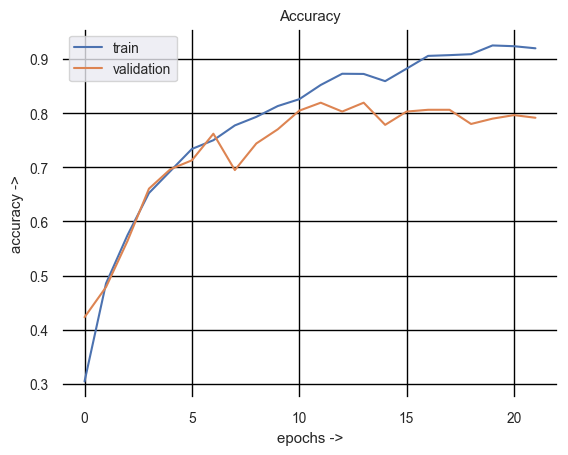

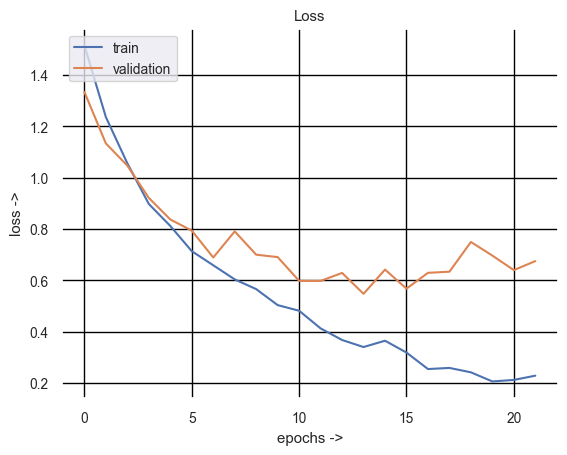

In [18]:
history_dict = utils.load_history(model_config['model_name'], dir=model_config['output_dir'])
epochs = model_config['epochs']
model_name = model_config['model_name']

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history_dict, ('categorial_accuracy', 'val_categorial_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/{model_name}_{epochs}_accuracy')
plot.plot_hist(history_dict, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/{model_name}_{epochs}_loss')

Predictions for the three different sets

In [12]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

#Loading in the model
model = utils.load_model(model_config['model_name'], dir=model_config['output_dir'])

# Training prediction
y_pred_train = predict(model, mel_train_n)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='weighted')*100:.4f} %")


# Validation prediction
y_pred_val = predict(model, mel_val_n)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_val, y_pred_val, average='weighted')*100:.4f} %")


# Test prediction
y_pred_test = predict(model, mel_test_n)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_test, y_pred_test, average='weighted')*100:.4f} %")

89/89 [==============================] - 3s 29ms/step
ACCURACY FOR TRAIN SET 90.6920 %
MACRO F1 SCORE FOR TRAIN SET 90.1448 %
MICRO F1 SCORE FOR TRAIN SET 90.6920 %
WEIGHTED F1 SCORE FOR TRAIN SET 90.7235 %
20/20 [==============================] - 1s 27ms/step
ACCURACY FOR VAL SET 81.9672 %
MACRO F1 SCORE FOR VAL SET 81.5098 %
MICRO F1 SCORE FOR VAL SET 81.9672 %
WEIGHTED F1 SCORE FOR TRAIN SET 81.9932 %
20/20 [==============================] - 1s 34ms/step
ACCURACY FOR TEST SET 83.4697 %
MACRO F1 SCORE FOR TEST SET 82.0645 %
MICRO F1 SCORE FOR TEST SET 83.4697 %
WEIGHTED F1 SCORE FOR TRAIN SET 83.4602 %


# Plot the confusion matrix on the test set
horizontal: predicted labels  
vertical: true labels

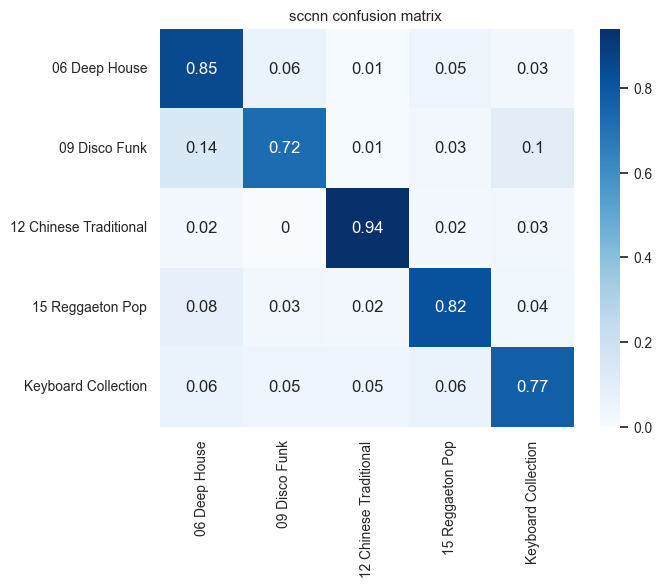

In [19]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

model_name = model_config['model_name']

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{model_name}_{epochs}_test_conf_mat.png", name=model_name)